<a href="https://colab.research.google.com/github/hakmin1015/PowerSystemEconomics/blob/main/etc/Practice/LSTM_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Practice 1-1

[정텐첫] 14. LSTM을 이용한 날씨 예측, 정채나 유튜브 참고

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/LoadForecasting/

Mounted at /content/drive/
/content/drive/MyDrive/LoadForecasting


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_excel('jeju_asos_data_2.xlsx')
df.head()     # 상위 5개 항목 출력
#print(len(df))    # time step = 1095

,date,max,min,TIME_1,TIME_2,TIME_3,TIME_4,TIME_5,TIME_6,TIME_7,...,TIME_22,TIME_23,TIME_24,p-temp,temp,rain,humidity,solar,cloud,wind
0,20210101,812,641,739,708,683,672,672,681,696,...,751,736,733,-1.4,5.5,0.0,54.4,2.55,9.3,3.8
1,20210102,851,599,697,673,652,649,653,664,681,...,813,802,801,-1.2,5.9,0.0,56.4,5.45,6.8,4.3
2,20210103,839,556,757,720,697,686,687,697,712,...,770,754,749,-1.5,4.5,NaN,57.0,7.85,7.8,2.5
3,20210104,873,673,711,689,677,674,685,702,739,...,774,748,740,-0.9,5.9,NaN,57.8,8.38,6.0,1.7
4,20210105,917,654,706,674,654,657,663,676,693,...,816,795,798,-2.6,5.6,0.0,66.0,2.77,9.5,4.0


전력max데이터만 가지고 전력max값 예측하기

In [ ]:
def univariate_data(dataset, start_idx, end_idx, history_size, target_size):
    data = []
    label = []

    start_idx = start_idx + history_size
    if end_idx is None:

        end_idx = len(dataset) - target_size

    for i in range(start_idx, end_idx):
        indices = range(i-history_size, i)
        data.append(np.reshape(dataset[indices],(history_size,1)))
        label.append(dataset[i:i+target_size])
    return np.array(data), np.array(label)

In [ ]:
# train data 1000개

train_split = 800   # 학습하는데 쓰는 데이터 개수
tf.random.set_seed(13)    # 인공지능 초기화?

In [ ]:
uni_data = df['max']
#uni_data.index = df['Date Time']
uni_data.head()

0    812
1    851
2    839
3    873
4    917
Name: max, dtype: int64

array([<Axes: >], dtype=object)

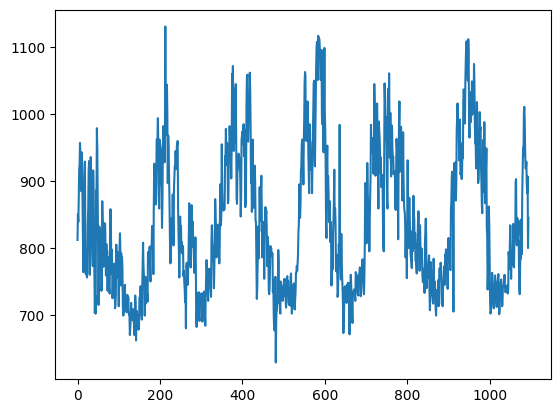

In [ ]:
uni_data.plot(subplots=True)

In [ ]:
max_data = uni_data.values

In [ ]:
# 데이터 표준화 (측정치-평균값) / 표준편차

uni_train_mean = max_data[:train_split].mean()
uni_train_std = max_data[:train_split].std()
max_data = (max_data - uni_train_mean) / uni_train_std

In [ ]:
x_train_uni, y_train_uni = univariate_data(max_data, 0, train_split, 20, 1)
x_val_uni, y_val_uni = univariate_data(max_data, train_split, None, 20, 1)

print(x_train_uni[0])
print(y_train_uni[0])

[[-0.25626608]
 [ 0.11990431]
 [ 0.00415958]
 [ 0.332103  ]
 [ 0.75650036]
 [ 0.82401812]
 [ 1.14231615]
 [ 0.96869904]
 [ 0.65040102]
 [ 0.44784773]
 [ 1.00728062]
 [ 0.95905365]
 [ 0.31281221]
 [-0.16945753]
 [-0.71924502]
 [ 0.34174839]
 [ 0.45749313]
 [ 0.65040102]
 [ 0.8722451 ]
 [-0.23697529]]
[-0.74818121]


In [ ]:
def create_time_steps(length):
    return list(range(-length,0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])

    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i , x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize= 10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

    plt.legend()
    plt.xlim([time_steps[0],(future+5)*2])
    plt.xlabel('Time Steps')
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

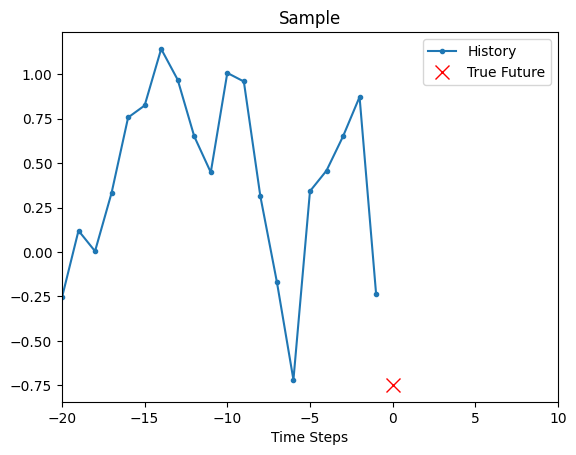

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

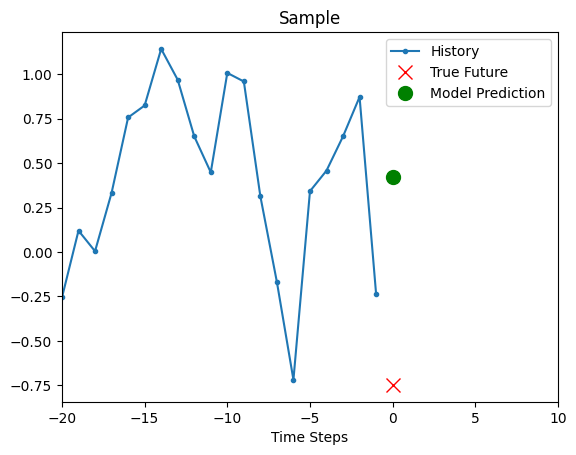

In [ ]:
def baseline(history):
    return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])],0, 'Sample')

In [ ]:
# LSTM

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(20).batch(16).repeat()

var_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
var_univariate = var_univariate.batch(2).repeat()

In [ ]:
print(x_train_uni.shape)
print(y_train_uni.shape)

(780, 20, 1)
(780, 1)


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape = x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mae')

In [ ]:
for x, y in train_univariate.take(1):
  print(model.predict(x).shape)

1/1 [==============================] - 1s 825ms/step
(16, 1)


In [ ]:
model.fit(train_univariate, epochs=10, steps_per_epoch=200, validation_data = var_univariate,validation_steps=50)

Epoch 1/10
200/200 [==============================] - 5s 11ms/step - loss: 0.4138 - val_loss: 0.2788
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.3581 - val_loss: 0.2727
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.3439 - val_loss: 0.2632
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.3271 - val_loss: 0.2502
Epoch 5/10
200/200 [==============================] - 2s 11ms/step - loss: 0.3119 - val_loss: 0.2450
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 0.3072 - val_loss: 0.2419
Epoch 7/10
200/200 [==============================] - 2s 10ms/step - loss: 0.3025 - val_loss: 0.2402
Epoch 8/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2978 - val_loss: 0.2407
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.3006 - val_loss: 0.2417
Epoch 10/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2992 - val_loss: 0.

1/1 [==============================] - 0s 22ms/step


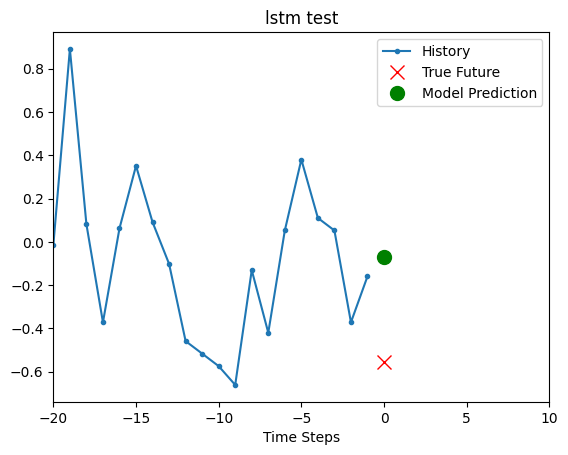

1/1 [==============================] - 0s 22ms/step


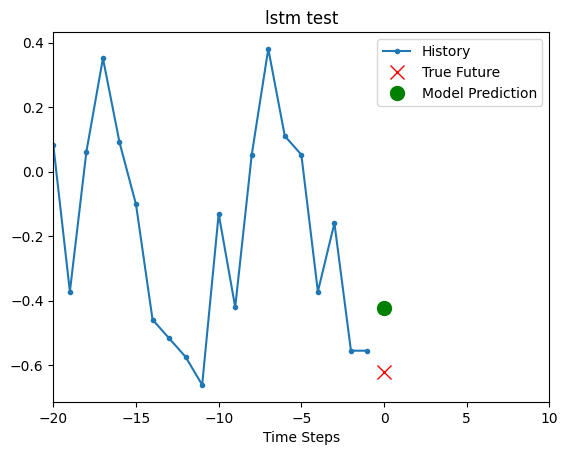

1/1 [==============================] - 0s 22ms/step


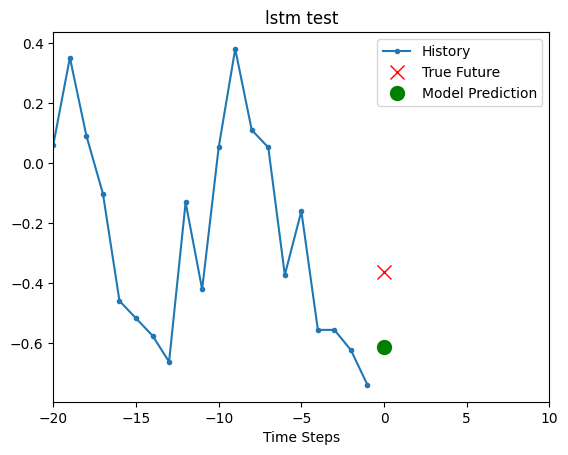

In [ ]:
for x,y in var_univariate.take(3):
    plot=show_plot([x[0].numpy(),y[0].numpy(),model.predict(x)[0]],0,'lstm test')
    plot.show()

LSTM 학습 결과 처음보다 오차가 줄었음을 확인할 수 있었음.

여러 외생변수를 이용하여 임의 시각의 전력 예측

In [ ]:
feature_con =['TIME_19','p-temp','humidity','solar','cloud'] # 최대, 체감온도
df = df.fillna(0)
feature = df[feature_con]
#feature.index = df['Date Time']
feature.head()

,TIME_19,p-temp,humidity,solar,cloud
0,812,-1.4,54.4,2.55,9.3
1,851,-1.2,56.4,5.45,6.8
2,839,-1.5,57.0,7.85,7.8
3,863,-0.9,57.8,8.38,6.0
4,906,-2.6,66.0,2.77,9.5


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

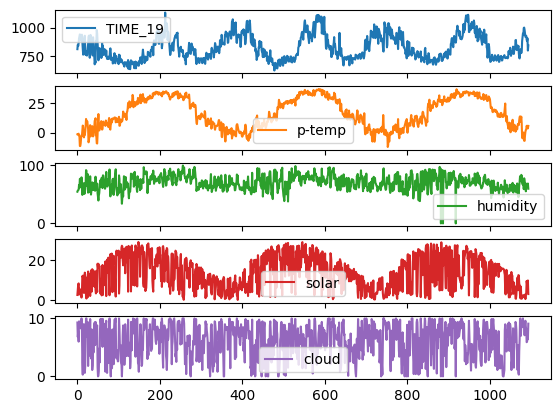

In [ ]:
feature.plot(subplots=True)

In [ ]:
dataset = feature.values
data_mean = dataset[:train_split].mean(axis=0)
data_std = dataset[:train_split].std(axis=0)
print(data_mean)
print(data_std)
dataset = (dataset-data_mean) / data_std

[827.27375   15.056125  70.65325   13.539125   6.1325  ]
[108.12171989  12.82413983  11.67339023   8.09048531   2.84086585]


In [ ]:
def multivariate_data(dataset, target, start_idx, end_idx, history_size, target_size, step, single_step=False):
    data = []
    label = []

    start_idx = start_idx + history_size
    if end_idx is None:
        end_idx = len(dataset) - target_size

    for i in range(start_idx, end_idx):
        indices = range(i - history_size, i+1, step)
        new_dataset=dataset[indices]
        new_dataset[-1][0] = 0    # 예측하는 날짜의 전력데이터 영향x
        data.append(new_dataset)

        if single_step:
            label.append(target[i+target_size])
        else:
            label.append(target[i:i+target_size])

    return np.array(data), np.array(label)

In [ ]:
x_train_single, y_train_single = multivariate_data(dataset, dataset[:,0], 0, train_split, 32, 1, 1, single_step = True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,0], train_split, None, 32, 1, 1, single_step = True)

In [ ]:
print(x_train_single[0].shape)

(33, 5)


In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(20).batch(64).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(2).repeat()

In [ ]:
single_model = tf.keras.models.Sequential()
single_model.add(tf.keras.layers.GRU(32,input_shape=x_train_single.shape[-2:], return_sequences=True))
single_model.add(tf.keras.layers.Activation('gelu'))
single_model.add(tf.keras.layers.GRU(32, return_sequences=True))
single_model.add(tf.keras.layers.Activation('gelu'))
single_model.add(tf.keras.layers.GRU(32))
single_model.add(tf.keras.layers.Dense(1))
single_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')
# model.compile(optimizer='adam', loss='mae')

In [ ]:
single_history = single_model.fit(train_data_single, epochs=10, steps_per_epoch=200, validation_data=val_data_single, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 18s 64ms/step - loss: 0.2856 - val_loss: 0.1448
Epoch 2/10
200/200 [==============================] - 12s 58ms/step - loss: 0.2145 - val_loss: 0.1425
Epoch 3/10
200/200 [==============================] - 12s 59ms/step - loss: 0.1916 - val_loss: 0.1315
Epoch 4/10
200/200 [==============================] - 10s 49ms/step - loss: 0.1732 - val_loss: 0.1610
Epoch 5/10
200/200 [==============================] - 12s 60ms/step - loss: 0.1595 - val_loss: 0.2029
Epoch 6/10
200/200 [==============================] - 12s 60ms/step - loss: 0.1455 - val_loss: 0.1767
Epoch 7/10
200/200 [==============================] - 12s 60ms/step - loss: 0.1311 - val_loss: 0.2075
Epoch 8/10
200/200 [==============================] - 12s 58ms/step - loss: 0.1213 - val_loss: 0.2208
Epoch 9/10
200/200 [==============================] - 11s 57ms/step - loss: 0.1107 - val_loss: 0.1983
Epoch 10/10
200/200 [==============================] - 12s 61ms/step - loss: 0.100

1/1 [==============================] - 2s 2s/step


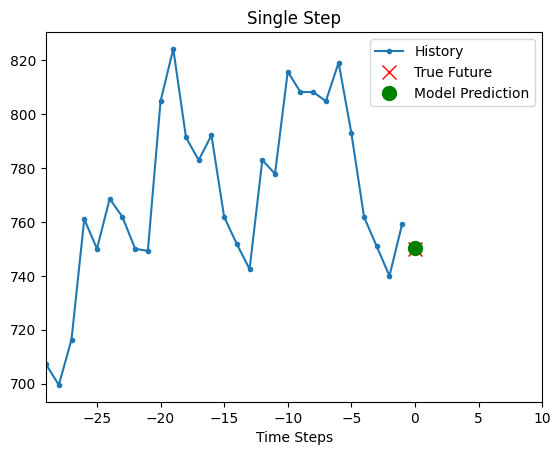

750.0
[750.1804]
[-0.02405599]
1/1 [==============================] - 0s 43ms/step


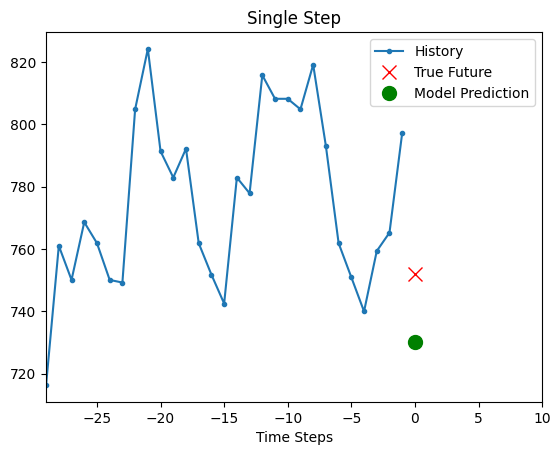

752.0
[730.0334]
[2.9210923]
1/1 [==============================] - 0s 40ms/step


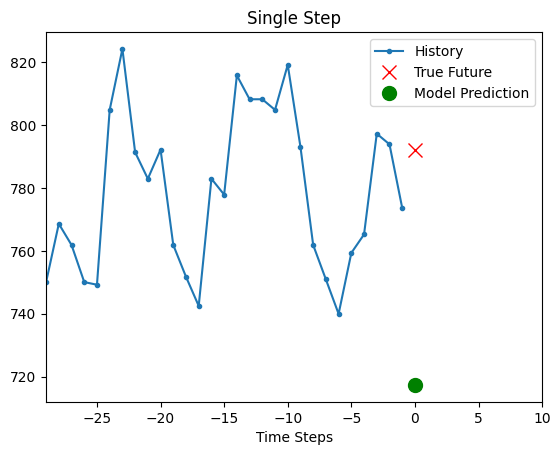

792.0
[717.3535]
[9.425061]


In [ ]:
for x, y in val_data_single.take(3):
    a = data_std[0] * x[0][:,1].numpy() + data_mean[0]
    b = data_std[0] * y[0].numpy() + data_mean[0]
    c = data_std[0] * single_model.predict(x)[0] + data_mean[0]
    plot = show_plot([a, b, c],0,'Single Step')
    plot.show()

    print(b)
    print(c)
    print((b-c)/b*100)